In [137]:
from pyiron_workflow import Workflow
import os
from pathlib import Path
import shutil
import json
import subprocess
import numpy as np

In [177]:
# Setup

# simulation
abq = "/isi/programs/simulia/2023_1/Commands/abaqus"
sim_path = ""  # not necessary
job_name = ""  # not necessary
eval_script_path = "/home/chri/w/OntOMat/Workflow/OntOMat_Workflow/Scripts/extract_homogenized_stiffness.py"
remove_folder = False  # not necessary

# materials
fiber_material_ID = "carbon"
matrix_material_ID = "PA6"

# micro
vol_frac = 0.4
fiber_rad = 0.3
RVE_depth_micro = 0.3
num_rad = 10
num_depth = 5
plugin_path = "/home/chri/w/OntOMat/Workflow/OntOMat_Workflow/Scripts/Abaqus_Plugin/MicroMechanics_v1.18/MicroMechanics"

# meso
orientations = [0,30,-30,60,-60,90]

# homogenized material IDs
micro_ID = "carbon_PA6_UD"
meso_ID = "carbon_PA6_laminate"

In [178]:
RVE_b_micro = np.sqrt(np.pi * fiber_rad**2 / (2 * vol_frac * np.tan(30 / 180 * np.pi)))
RVE_h_micro = RVE_b_micro * np.tan(30 / 180 * np.pi)
RVE_volume_micro = 4 * RVE_h_micro * RVE_b_micro * RVE_depth_micro

In [179]:
# Generate/Delete Folder


@Workflow.wrap.as_function_node
def generate_sim_folder(sim_path: str = "") -> str:
    """
    Generate simulation folder.

    Parameters
    ----------
    sim_path : str
        Simulation folder path.

    Returns
    -------
    sim_path : str
        Simulation folder path.
    """

    if sim_path == "":
        cwd = os.getcwd()
        sim_path = cwd + "/sim_tmp/"

    Path(sim_path).mkdir(parents=True, exist_ok=True)

    return sim_path


@Workflow.wrap.as_function_node
def remove_sim_folder(remove: bool = True, sim_path: str = ""):
    """
    Remove simulation folder.

    Parameters
    ----------
    remove : bool
        Flag to remove the folder or not.
    sim_path : str
        Simulation folder path.

    """
    if remove:
        shutil.rmtree(sim_path)

In [180]:
# OntOMat Query


@Workflow.wrap.as_function_node
def ontomat_query(
    fiber_material_ID: str, matrix_material_ID: str, sim_path: str
) -> tuple[dict, str]:
    """
    Return material parameters based on a SPARQL query to KG of OntOMat.

    Parameters
    ----------
    fiber_material_ID : str
        Unique ID of fiber material.
    matrix_material_ID : str
        Unique ID of matrix material.
    sim_path : str
        Path to simulation folder.

    Returns
    -------
    materials : dict
        Relevant material parameters.
    sim_path : str
        Simulation folder path.
    """

    # For now dummy data

    materials = dict()

    if fiber_material_ID == "carbon":
        materials["fiber"] = {
            "name": "carbon",
            "symmetry_class": "isotropic",
            "E": 230e3,
            "nu": 0.1,
        }
    else:
        raise ValueError("Fiber material not supported.")

    if matrix_material_ID == "PA6":
        materials["matrix"] = {
            "name": "PA6",
            "symmetry_class": "isotropic",
            "E": 2e3,
            "nu": 0.33,
        }
    else:
        raise ValueError("Matrix material not supported.")

    return materials, sim_path


@Workflow.wrap.as_function_node
def ontomat_upload(material_ID: str, material_coefficients: dict):
    """
    Upload material parameters to KG of OntOMat.

    Parameters
    ----------
    material_ID : str
        Unique ID of material.
    material_coefficients : dict
        Dictionary containing the stiffness components in Mandel notation.
    """

    # upload
    # stuff
    # to
    # knowledge
    # graph

    print("Uploading to OntOMat knowledge graph...")

    return

In [181]:
# Pre-Process

@Workflow.wrap.as_function_node
def pre_process_micro(
    materials: dict,
    sim_path: str,
    plugin_path: str,
    abq: str,
    cae_name: str = "micro_structure.cae",
    job_name: str = "UD_hex_homogen",
    vol_frac: float = 0.1,
    fiber_rad: float = 0.3,
    interface_ratio: float = 0.0,
    depth: float = 0.3,
    num_rad: int = 10,
    num_depth: int = 5,
) -> tuple[str, str]:
    """
    Perfom pre-process of FEM simulation and generate files.

    Parameters
    ----------
    materials : dict
        Dict containing stiffness parameters of constituents.
    sim_path : str
        Simulation folder path.
    plugin_path : str
        Path to the Abaqus MicroMechanics Plugin.
    abq : str
        Path to the Abaqus executable.
    cae_name : str
        Name of the CAE file which will be generated.
    job_name : str
        Name of FEM job file.
    vol_frac : float
        Fiber volume fraction.
    fiber_rad : float
        Fiber radius.
    interface_ratio : float
        Fraction of interface thickness to fiber radius.
    depth : float
        Depth of the RVE.
    num_rad : int
        Numbers of FE elements in radial direction of fiber.
    num_depth : int
        Number of FE elements in depth direction of RVE.

    Returns
    -------
    sim_path : str
        Simulation folder path.
    job_name : str
        Name of FEM job file.
    """

    fiber = dict()
    fiber["volume_content"] = vol_frac
    fiber["radius"] = fiber_rad
    fiber["interface_ratio"] = interface_ratio
    fiber["name"] = materials["fiber"]["name"]
    fiber["symmetry_class"] = materials["fiber"]["symmetry_class"]
    fiber["E"] = materials["fiber"]["E"]
    fiber["nu"] = materials["fiber"]["nu"]

    matrix = dict()
    matrix["name"] = materials["matrix"]["name"]
    matrix["symmetry_class"] = materials["matrix"]["symmetry_class"]
    matrix["E"] = materials["matrix"]["E"]
    matrix["nu"] = materials["matrix"]["nu"]

    mesh = dict()
    mesh["num_rad"] = num_rad
    mesh["num_depth"] = num_depth

    geometry = dict()
    geometry["depth"] = depth
    geometry["mesh"] = mesh

    micro = dict()
    micro["fiber"] = fiber
    micro["matrix"] = matrix
    micro["geometry"] = geometry

    simulation = dict()
    simulation["sim_path"] = sim_path
    simulation["plugin_path"] = plugin_path
    simulation["cae_name"] = cae_name
    simulation["job_name"] = job_name

    abaqus_micro_input = dict()
    abaqus_micro_input["micro"] = micro
    abaqus_micro_input["simulation"] = simulation
    abaqus_micro_input_json = json.dumps(abaqus_micro_input, indent=2, sort_keys=True)

    abaqus_json_path = sim_path + "abaqus_micro.json"

    with open(abaqus_json_path, "w") as abaqus_json_file:
        abaqus_json_file.write(abaqus_micro_input_json)

    call_command = abq + " cae noGUI=generate_cae_micro.py -- {}".format(
        abaqus_json_path
    )

    # subprocess.call(call_command, shell=True)

    return sim_path, job_name


@Workflow.wrap.as_function_node
def pre_process_meso(
    material: dict,
    orientations: list,
    sim_path: str,
    plugin_path: str,
    abq: str,
    cae_name: str = "meso_structure.cae",
    job_name: str = "UD_laminate_homogen",
) -> tuple[str, str]:
    """
    Perfom pre-process of FEM simulation and generate files.

    Parameters
    ----------
    material : dict
        Dict containing homogenized stiffness parameters.
    orientations: list,
        Laminate angles.
    sim_path : str
        Simulation folder path.
    plugin_path : str
        Path to the Abaqus MicroMechanics Plugin.
    abq : str
        Path to the Abaqus executable.
    cae_name : str
        Name of the CAE file which will be generated.
    job_name : str
        Name of FEM job file.

    Returns
    -------
    sim_path : str
        Simulation folder path.
    job_name : str
        Name of FEM job file.
    """

    meso = dict()
    meso["orientations"] = orientations
    meso["material_parameters"] = material

    simulation = dict()
    simulation["sim_path"] = sim_path
    simulation["plugin_path"] = plugin_path
    simulation["cae_name"] = cae_name
    simulation["job_name"] = job_name

    abaqus_meso_input = dict()
    abaqus_meso_input["meso"] = meso
    abaqus_meso_input["simulation"] = simulation
    abaqus_meso_input_json = json.dumps(abaqus_meso_input, indent=2, sort_keys=True)

    abaqus_json_path = sim_path + "abaqus_meso.json"

    print(abaqus_json_path)

    with open(abaqus_json_path, "w") as abaqus_json_file:
        abaqus_json_file.write(abaqus_meso_input_json)

    call_command = abq + \
        ' cae noGUI=generate_cae_meso.py -- {}'.format(
            abaqus_json_path)

    subprocess.call(call_command, shell=True)

    return sim_path, job_name

In [182]:
# Abaqus Runner

@Workflow.wrap.as_function_node
def abaqus_runner(
    sim_path: str,
    job_name: str,
    abaqus_cores: int = 1,
    abaqus_version: str = "2023",
    lic_server: str = "lic5",
) -> tuple[str, str]:
    """
    Generate and send Abaqus job file to solver.

    Parameters
    ----------
    sim_path : str
        Simulation folder path.
    job_name : str
        Name of FEM job file.
    abaqus_cores : int
        Number of cores for Abaqus solver.
    abaqus_version : str
        Abaqus version of solver.
    lic_server : str : str
        License server for Abaqus solver.

    Returns
    -------
    sim_path : str
        Simulation folder path.
    job_name : str
        Name of FEM job file.
    """

    call_command = "cd {sim_path}; abawrapper -v {abaqus_version} -j {job_name} -cpus {abaqus_cores} -l {lic_server} -inter".format(
        sim_path=sim_path,
        abaqus_version=abaqus_version,
        job_name=job_name,
        abaqus_cores=abaqus_cores,
        lic_server=lic_server,
    )

    subprocess.call(call_command, shell=True)

    return sim_path, job_name

In [186]:
# Abaqus Evaluator


@Workflow.wrap.as_function_node
def abaqus_evaluator(
    sim_path: str,
    job_name: str,
    abq: str,
    eval_script_path: str,
    RVE_volume: float=1.0
) -> tuple[str, dict, dict]:
    """
    Evaluate Abaqus ODB file.

    Parameters
    ----------
    sim_path : str
        Simulation folder path.
    job_name : str
        Name of FEM job file.
    abq : str
        Path to the Abaqus executable.
    eval_script_path : str
        Path to Python script to evaluate ODB file.
    RVE_volume : float
        Volume of RVE.

    Returns
    -------
    sim_path : str
        Simulation folder path.
    homogen_Voigt_json : dict
        Dictionary containing the homogenized 21 stiffness components in Voigt notation.
    homogen_Mandel_json : dict
        Dictionary containing the homogenized 21 stiffness components in Mandel notation.
    """

    call_command = abq + " cae noGUI={} -- {} {} {}".format(
        eval_script_path, sim_path, job_name, RVE_volume
    )

    subprocess.call(call_command, shell=True)

    homogen_Voigt_json_path = sim_path + job_name + "_homogenized_stiffness_voigt.json"

    with open(homogen_Voigt_json_path, "r") as json_file:
        homogen_Voigt_json = json.load(json_file)

    homogen_Mandel_json_path = sim_path + job_name + "_homogenized_stiffness_mandel.json"

    with open(homogen_Mandel_json_path, "r") as json_file:
        homogen_Mandel_json = json.load(json_file)

    return sim_path, homogen_Voigt_json, homogen_Mandel_json

In [191]:
# Construct workflow

wf = Workflow("micro_simulation")

# micro simulation ...

wf.generate_sim_folder = generate_sim_folder()
wf.ontomat_query = ontomat_query(sim_path=wf.generate_sim_folder.outputs.sim_path)
wf.pre_process_micro = pre_process_micro(
    materials=wf.ontomat_query.outputs.materials,
    sim_path=wf.ontomat_query.outputs.sim_path,
)
wf.abaqus_runner_micro = abaqus_runner(
    sim_path=wf.pre_process_micro.outputs.sim_path,
    job_name=wf.pre_process_micro.outputs.job_name,
)
wf.abaqus_evaluator_micro = abaqus_evaluator(
    sim_path=wf.abaqus_runner_micro.outputs.sim_path,
    job_name=wf.abaqus_runner_micro.outputs.job_name,
)
wf.ontomat_upload_micro = ontomat_upload(
    material_coefficients=wf.abaqus_evaluator_micro.outputs.homogen_Mandel_json
)

# meso simulation ...

wf.pre_process_meso = pre_process_meso(
    material=wf.abaqus_evaluator_micro.outputs.homogen_Voigt_json,
    sim_path=wf.abaqus_evaluator_micro.outputs.sim_path
)
wf.abaqus_runner_meso = abaqus_runner(
    sim_path=wf.pre_process_meso.outputs.sim_path,
    job_name=wf.pre_process_meso.outputs.job_name,
)
wf.abaqus_evaluator_meso= abaqus_evaluator(
    sim_path=wf.abaqus_runner_meso.outputs.sim_path,
    job_name=wf.abaqus_runner_meso.outputs.job_name,
)
wf.ontomat_upload_meso = ontomat_upload(
    material_coefficients=wf.abaqus_evaluator_meso.outputs.homogen_Mandel_json
)

# finish...

wf.remove_sim_folder = remove_sim_folder(
    sim_path=wf.abaqus_evaluator_meso.outputs.sim_path
)

In [188]:
# Run workflow with input parameters

wf(
    ontomat_query__fiber_material_ID=fiber_material_ID,
    ontomat_query__matrix_material_ID=matrix_material_ID,
    pre_process_micro__plugin_path=plugin_path,
    pre_process_micro__abq=abq,
    pre_process_micro__vol_frac=vol_frac,
    pre_process_micro__fiber_rad=fiber_rad,
    pre_process_micro__depth=RVE_depth_micro,
    pre_process_micro__num_rad=num_rad,
    pre_process_micro__num_depth=num_depth,
    abaqus_evaluator_micro__abq=abq,
    abaqus_evaluator_micro__eval_script_path=eval_script_path,
    abaqus_evaluator_micro__RVE_volume=RVE_volume_micro,
    ontomat_upload_micro__material_ID=micro_ID,
    pre_process_meso__orientations=orientations,
    pre_process_meso__plugin_path=plugin_path,
    pre_process_meso__abq=abq,
    abaqus_evaluator_meso__abq=abq,
    abaqus_evaluator_meso__eval_script_path=eval_script_path,
    ontomat_upload_meso__material_ID=meso_ID,
    remove_sim_folder__remove=remove_folder,
)

Wait for Abaqus job 'UD_hex_homogen' to finish ...
JobID           JobName  Partition    Account  AllocCPUS      State ExitCode 
628218       UD_hex_ho+     abaqus   hpc-user          1  COMPLETED      0:0 


Abaqus License Manager checked out the following license:
"cae" from Flexnet server lic5
<0 out of 1 licenses remain available>.


/isi/w/chri/OntOMat/Workflow/OntOMat_Workflow/Notebooks/sim_tmp/abaqus_meso.json


Abaqus License Manager checked out the following license:
"cae" from Flexnet server lic5
<0 out of 1 licenses remain available>.


Uploading to OntOMat knowledge graph...
Wait for Abaqus job 'UD_laminate_homogen' to finish ...
JobID           JobName  Partition    Account  AllocCPUS      State ExitCode 
628219       UD_lamina+     abaqus   hpc-user          1  COMPLETED      0:0 


Abaqus License Manager checked out the following license:
"cae" from Flexnet server lic5
<0 out of 1 licenses remain available>.


Uploading to OntOMat knowledge graph...


{'ontomat_upload_micro__None': None,
 'abaqus_evaluator_meso__sim_path': '/isi/w/chri/OntOMat/Workflow/OntOMat_Workflow/Notebooks/sim_tmp/',
 'abaqus_evaluator_meso__homogen_Voigt_json': {'C11': 38692.1640625,
  'C12': 12974.9326171875,
  'C13': 2183.06005859375,
  'C14': 0.0009811300551518798,
  'C15': -1.0449641152376898e-10,
  'C16': 7.2354566782451e-11,
  'C22': 38692.1640625,
  'C23': 2183.06005859375,
  'C24': 0.0018869841005653143,
  'C25': 2.1262991367621e-12,
  'C26': 1.2562173523633646e-10,
  'C33': 5684.7900390625,
  'C34': -2.326966932741925e-05,
  'C35': 1.922328962677966e-11,
  'C36': -6.079292624860955e-11,
  'C44': 12858.6142578125,
  'C45': 5.487988882779682e-11,
  'C46': -1.3670826623513044e-11,
  'C55': 1647.5518798828125,
  'C56': 5.162351953913458e-06,
  'C66': 1647.5518798828125},
 'ontomat_upload_meso__None': None,
 'remove_sim_folder__None': None}

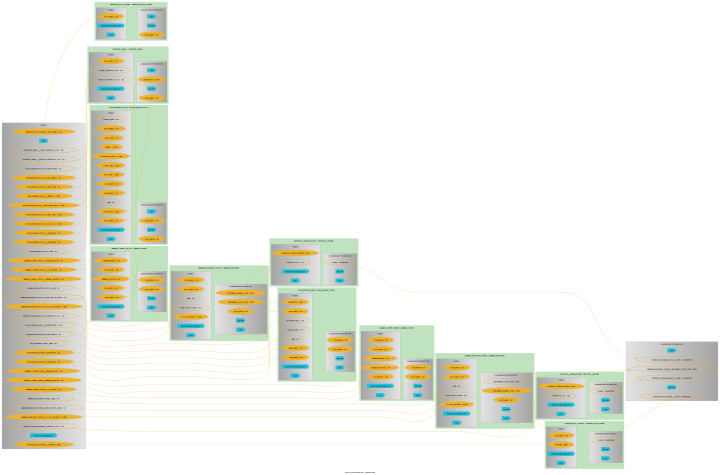

In [192]:
wf.draw(size=(10,10),filename="/isi/w/chri/OntOMat/Workflow/OntOMat_Workflow/Notebooks/WF")